Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [14]:
NAME = "Georgios Evangelos Margaritis"
COLLABORATORS = ""

---

# CSC_51073_EP Lab4 : stereo imagery

The goal of this lab is to manipulate a stereo image pair

In [15]:
%matplotlib inline

import numpy as np # grey images are stored in memory as 2D arrays, color images as 3D arrays
import cv2 as cv2 # opencv computer vision library
from skimage import io # for io.imread
from matplotlib import pyplot as plt # ploting
from matplotlib import colors # ploting

# interactive notebook widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

This `imshow` function is provided to display arrays of `images` with `titles`.
It accepts a callback for interactive plotting (using the %matplotlib notebook context) 

In [16]:
def imshow(images, titles, callback = None, nrows = 0, ncols=0):
    """Plot a multiple images with titles.

    Parameters
    ----------
    images : image list
    titles : title list
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    if ncols == 0 and nrows == 0:
      ncols = len(images)
      nrows = 1
    if ncols == 0:
      ncols = len(images) // nrows
    if nrows == 0:
      nrows = len(images) // ncols
      
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, squeeze=False, figsize = None)
    for i, image in enumerate(images):
        axeslist.ravel()[i].imshow(image, cmap=plt.gray(), vmin=0, vmax=255)
        axeslist.ravel()[i].set_title(titles[i])
        axeslist.ravel()[i].set_axis_off()
    plt.tight_layout() # optional

    text=fig.text(0,0, "", va="bottom", ha="left")
    def onclick(event):
        [i],[j] = np.where(axeslist == event.inaxes)
        callback(axeslist, [i,j], [event.xdata, event.ydata], text)
    
    # Create an hard reference to the callback not to be cleared by the garbage collector
    ka = fig.canvas.mpl_connect('button_press_event', onclick)
    return axeslist

Here are 2 images, taken from slightly different positions. Please download the image locally if you can to save some internet bandwith.

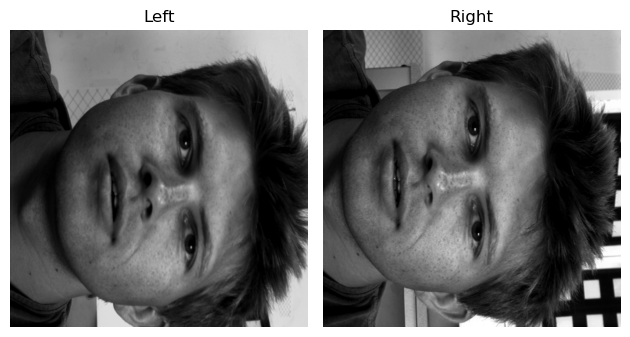

In [17]:
url1  = 'face00.tif'
url2  = 'face01.tif'
# url1  = 'https://www.umr-lastig.fr/mathieu-bredif/data/face00.tif'
# url2  = 'https://www.umr-lastig.fr/mathieu-bredif/data/face01.tif'
image1  = io.imread(url1) 
image2  = io.imread(url2) 
axeslist = imshow([image1, image2], ['Left', 'Right'])

# Q0 Cameras

Using np.dot and np.linalg.inv, implement the Camera functions.

Check that the projection by a camera of its center point yields a point very close to (0,0,0), which means is Cartesian position is ill-defined.

In [18]:
class Camera:
    def __init__(self, params):
        # self.b = np.array([params[?:?], params[?:?], params[?:?]])
        # self.b = np.array(params[?:?:?])
        # Reshape the 12 parameters into a 3x4 projection matrix
        self.b = np.array([params[0:4], params[4:8], params[8:12]])

    def center(self):
        # The camera center C satisfies P * [C; 1] = 0
        # Then C = -A^(-1) * b
        A = self.b[:, :3]  # 3x3 left submatrix
        b = self.b[:, 3]   # 3x1 right column
        return -np.dot(np.linalg.inv(A), b)

    def proj(self, p):               # 3D point p to homogeneous 2D coordinates
        p_hom = np.append(p, 1)      # converting p to homogeneous coordinates [x, y, z, 1]   
        return np.dot(self.b, p_hom) # Apply the projection matrix

    
cam1 = Camera([
    1.008625769,   -.1231000000,   -2.726496908,   100.7731396,
    .8361681672,   4.182806666,   .09730552466,   157.7821517,
    .001940031162,   -.0002500000000,   .0004294973553,   .5091827970
])

cam2 = Camera([
    1.426624453,   -.1471000000,   -2.539954861,   78.3047630,
    .7976452886,   4.150586666,   .1303686090,   143.3641217,
    .001903601260,   -.0001466666667,   .0006532670189,   .5012476834
])

p1 = cam1.proj(cam1.center()) 
print(p1)

p2 = cam2.proj(cam2.center())
print(p2)

[0. 0. 0.]
[-1.42108547e-14  0.00000000e+00  0.00000000e+00]


In [19]:
assert p2.dot(p2) < 1e-25 
assert p1.dot(p1) < 1e-25

print(p1.dot(p1))
print(p2.dot(p2))

0.0
2.0194839173657902e-28


# Q1. Computing the epipole

Compute the homogeneous coordinates of the projection in the image space of camera1 of the 3D center point of camera 2.

In [20]:
def epipole(camera_1, camera_2):
    center_2 = camera_2.center()      # the 3D center of camera2
    return camera_1.proj(center_2)    # project it into the image space of camera1

e1 = epipole(cam1, cam2)
print("e1 (homogeneous coordinates)= ",e1)
print("e1 (cartesian coordinates)= ",e1[:-1]/e1[-1])

e1 (homogeneous coordinates)=  [1.36667899e+02 9.26334198e+00 2.03139041e-02]
e1 (cartesian coordinates)=  [6727.80072724  456.00992885]


# Q2. Computing the fundamental Matrix

Using the formula $F_{12} = [e_2]_\times \cdot A_2 \cdot A_1^{-1}$, compute now the fundamental matrix between cameras 1 and 2, where
- $e_2$ is the epipole in image 2, and $E_2=[e_2]_\times$ the matrix coding the vector product by $e_2$
- $A_1$ and $A_2$ are the 3x3 left submatrix of the camera 4x3 projection matrices 
- $\cdot$ denotes the matrix product (np.matmul)


In [21]:
def fundamental(camera1, camera2):
    
    e2 = epipole(camera2, camera1)     # the projection of camera1's center in camera2's image space
    E2 = np.array([[0, -e2[2], e2[1]], # E2 is the skew-symmetric matrix of e2
                   [e2[2], 0, -e2[0]],
                   [-e2[1], e2[0], 0]])
    
    # left submatrices of the camera projection matrices
    A1 = camera1.b[:, :3]
    A2 = camera2.b[:, :3]
    F12 = np.matmul(E2, np.matmul(A2, np.linalg.inv(A1))) # [e2]x * A2 * inv(A1)
    return F12

F12 = fundamental(cam1, cam2)
print("F12 = ",F12)

F12 =  [[ 4.26008518e-04  9.69590030e-03 -7.28752722e+00]
 [-2.04890531e-02  3.09733202e-03  1.36433852e+02]
 [ 8.77835694e+00 -1.35769101e+02  2.85302172e+03]]


Compute F21 efficiently by reusing F12, rather than recomputing it from scratch with cam1 and cam2.

In [22]:
F21 = fundamental(cam2, cam1)
F = [F12, F21] # for convenience, place F12 and F21 in a array F
F

[array([[ 4.26008518e-04,  9.69590030e-03, -7.28752722e+00],
        [-2.04890531e-02,  3.09733202e-03,  1.36433852e+02],
        [ 8.77835694e+00, -1.35769101e+02,  2.85302172e+03]]),
 array([[ 4.30413099e-04, -2.07008932e-02,  8.86911801e+00],
        [ 9.79614803e-03,  3.12935592e-03, -1.37172843e+02],
        [-7.36287433e+00,  1.37844467e+02,  2.88251964e+03]])]

## Q3 Epipolar lines

Implement 
- get_epipolar_line : the computation of the epipolar line in the other image, knowing a 2D point and the fundamental matrix
- get_y_at_x : the y coordinate of the intersection of a line l and the vertical line at x (such that $ l \cdot (x,y,1) == 0$ ).

You can now check your implementation by clicking on either of the 2 images : the corresponding epipolar line will be drawn on the other image. Click on details (eye highlight, tip of the ear, skin marks/freckles...) and check if its epipolar line is indeed going through the same detail in the other image.

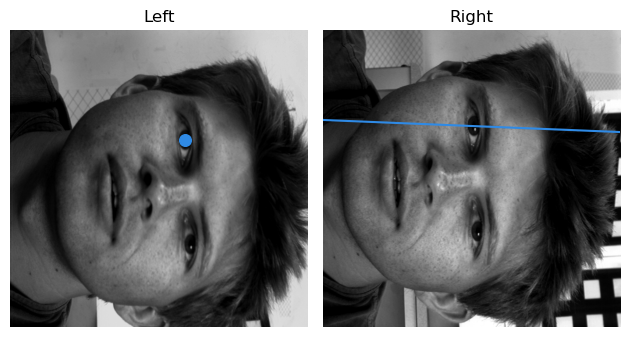

In [23]:
def get_epipolar_line(point, f):
    P = np.array([point[0], point[1], 1])  # homogeneous coordinates
    l = np.dot(f, P)                       # The epipolar line is l = F * P
    return l

def get_y_at_x(line, x):    
    # line equation: l[0]*x + l[1]*y + l[2] = 0
    # Solving for y: y = -(l[0]*x + l[2]) / l[1]
    return -(line[0] * x + line[2]) / line[1]
    
def draw_epipolar_line(axe1, axe2, point, f, color):
    l = get_epipolar_line(point, f)
    # to draw it, we need 2 arbitrary points,
    # let's take its intercept with x=0 and x=1
    x0 = 0
    x1 = 1
    p0 = [x0, get_y_at_x(l, x0)]
    p1 = [x1, get_y_at_x(l, x1)]
    axe2.axline(p0, p1, color = color)
    # draw the clicked point with the same color
    axe1.scatter([point[0]], [point[1]], color=[color], marker='o', s=70) 


def onclick_draw_epipolar_line(axeslist, ij, p, text = None):
    i = ij[0] # == 0
    j = ij[1] # == 0 or 1 for left or right image
    # take a random color
    color = np.random.rand((3))
    draw_epipolar_line(axeslist[i, j], axeslist[i, 1-j], p, F[j], color)
    
axeslist = imshow( [image1, image2], ['Left', 'Right'], onclick_draw_epipolar_line)
onclick_draw_epipolar_line(axeslist, [0,0], [300,190])

## Q4: Zero-Mean Cross Correlation

Implement the Zero-Mean Cross Correlation (ZNCC) computation, so that when you click on a point in one image, it shows:
- the epipolar line, but also
- the graph with positive ZNCC scores
- the point with the best ZNCC score on the epipolar line


In [24]:
print(image1.shape)
print(image1.shape[0])
print(image1.shape[1])
print("---")
print(image2.shape)
print(image2.shape[0])
print(image2.shape[1])

(512, 512)
512
512
---
(512, 512)
512
512


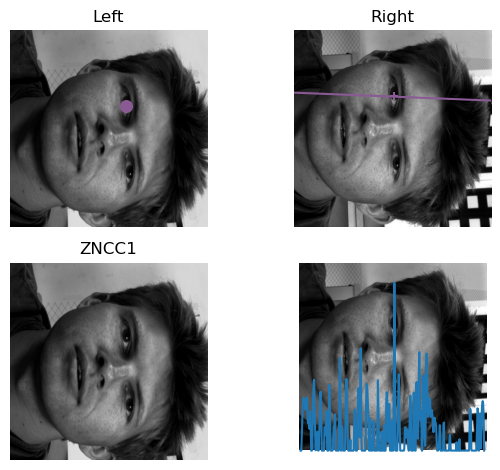

In [25]:
images = [image1, image2]

def compute_zncc(img1, img2, l, p, window):

    xs = np.arange(window, img2.shape[1] - window)                                              # xs takes all values so that [x-window, x+window] is inside img2 
    ys = np.minimum(img2.shape[0]-window-1,np.maximum(window, np.uint32(get_y_at_x(l,xs))))     # ys are the y coordinates of the points on line l at the given x coordinates
                                                                                                # these coordinates are also clamped so that they are away from the image boundary
    x1 = np.minimum(img1.shape[1]-window-1,np.maximum(window, np.uint32(p[0])))
    y1 = np.minimum(img1.shape[0]-window-1,np.maximum(window, np.uint32(p[1])))
    
    zncc = np.float32(np.zeros_like(xs))  # zncc will return the zncc score at each x-coordinate
    
    for ix, (x2,y2) in enumerate(zip(xs, ys)):
        # I1 and I2 are the 2 [2*window+1]x[2*window+1] image patches centered  at x1,y1 and x2,y2
        I1 = np.float32(img1[y1-window:y1+window+1, x1-window:x1+window+1])
        I2 = np.float32(img2[y2-window:y2+window+1, x2-window:x2+window+1])
        
        I1 -= np.mean(I1)  # (-=) equals I1 = I1 - np.mean(I1)
        I2 -= np.mean(I2)  # Makes the algorithm insensitive to brightness differences (the "Zero-Mean" part)
        std1 = np.std(I1) 
        std2 = np.std(I2)
        denom = std1 * std2
        if  denom != 0:
            zncc[ix] = np.sum(I1 * I2) / (denom * I1.size)
        
    return xs, ys, zncc

def onclick_draw_NCC_match_and_epipolar_line(axeslist, ij, p, text = None):
    window = 5
    j = ij[1] # == 0 or 1 for left or right image
    l = get_epipolar_line(p, F[j])
    color = np.random.rand((3))
    
    img1 = images[j]
    img2 = images[1-j]
    
    xs, ys, zncc = compute_zncc(img1, img2, l, p, window)
    
    imax = np.argmax(zncc) 
    
    xmax = xs[imax]
    ymax = ys[imax]

    axeslist[0,1-j].scatter([xmax], [ymax], color=[color], marker='+')
    draw_epipolar_line(axeslist[0, j], axeslist[0, 1-j], p, F[j], color)
    axes = axeslist[1, 1-j]
    axes.clear()
    axes.imshow(img2, cmap=plt.gray(), vmin=0, vmax=255)
    axes.set_axis_off()
    axes.plot(xs, img2.shape[0]*np.minimum(1, 1-zncc))
    

axeslist = imshow( [image1, image2, image1, image2], ['Left', 'Right', 'ZNCC1', 'ZNCC2'], onclick_draw_NCC_match_and_epipolar_line, nrows=2)
onclick_draw_NCC_match_and_epipolar_line(axeslist, [0,0], (302,196))